In [6]:
import array_api_compat.torch as xp
import parallelproj
from array_api_compat import to_device
import array_api_compat.numpy as np
import matplotlib.pyplot as plt
from utils.geometry import * 
from utils.data import *
from odl.solvers.iterative.statistical import mlem
from einops import rearrange
from odl.contrib import fom
import matplotlib.gridspec as gridspec

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)

proj = get_minipet_projector(dev,num_rings=35)

In [16]:
rs=odl.uniform_discr([  0. , -21.9, -21.9], [  0.675,  22.2  ,  22.2  ], (147, 147, 60), dtype='float32')
SLP = odl.phantom.shepp_logan(rs,modified=True)

SLP_slices = torch.flip(rearrange(to_device(
    torch.tensor(SLP, dtype=torch.float64),
    dev), 'w h d -> h d w')[:,13:48,:].unsqueeze(0),[1])

SLP_slices[SLP_slices < 0] = 0
blurred_slices = blur_image(SLP_slices, kernel_size=5, sigma=2.0)
#blurred_slices = SLP_slices
sino = generate_data(blurred_slices,proj,noise_level=0.7).squeeze(0).squeeze(0)

n = 20
x = torch.ones((147,35,147)).to(dev)
sol = torch.zeros(n,147,35,147)
sens = proj.adjoint(torch.ones(sino.shape).to(dev))
for i in range(n):
    ssim_list = []
    psnr_list = []

    forward_proj = proj(x)

    ratio = sino / (forward_proj + 1e-9)

    backward_proj = proj.adjoint(ratio)

    x *= backward_proj / sens

    for j in range(proj.in_shape[1]):
        psnr_list.append(fom.psnr(x[:,j,:].cpu().numpy(),SLP_slices[0,:,j,:].cpu().numpy()))
        ssim_list.append(fom.ssim(x[:,j,:].cpu().numpy(),SLP_slices[0,:,j,:].cpu().numpy()))

    loss = torch.nn.functional.mse_loss(x,SLP_slices[0])
    sol[i] = x
    print("{}/{} - loss {:.5f}; PSNR {:.3f}; SSIM {:.3f}".format(i+1, n, loss, np.mean(psnr_list), np.mean(ssim_list)))

1/20 - loss 0.03626; PSNR 14.409; SSIM 0.296
2/20 - loss 0.03083; PSNR 15.116; SSIM 0.316
3/20 - loss 0.02685; PSNR 15.718; SSIM 0.340
4/20 - loss 0.02385; PSNR 16.235; SSIM 0.382
5/20 - loss 0.02151; PSNR 16.684; SSIM 0.439
6/20 - loss 0.01968; PSNR 17.072; SSIM 0.498
7/20 - loss 0.01823; PSNR 17.405; SSIM 0.547
8/20 - loss 0.01708; PSNR 17.689; SSIM 0.583
9/20 - loss 0.01617; PSNR 17.928; SSIM 0.608
10/20 - loss 0.01544; PSNR 18.129; SSIM 0.624
11/20 - loss 0.01486; PSNR 18.296; SSIM 0.634
12/20 - loss 0.01440; PSNR 18.433; SSIM 0.639
13/20 - loss 0.01404; PSNR 18.544; SSIM 0.641
14/20 - loss 0.01376; PSNR 18.632; SSIM 0.642
15/20 - loss 0.01355; PSNR 18.701; SSIM 0.641
16/20 - loss 0.01339; PSNR 18.753; SSIM 0.639
17/20 - loss 0.01328; PSNR 18.790; SSIM 0.637
18/20 - loss 0.01321; PSNR 18.815; SSIM 0.634
19/20 - loss 0.01317; PSNR 18.829; SSIM 0.631
20/20 - loss 0.01317; PSNR 18.833; SSIM 0.628


In [18]:
import nibabel

real=nibabel.load('/home/mamo_alegua/anaconda3/ThesisCodeminiPET/Mouse4/sino40min.sino.mnc')
#real=nibabel.load('/home/mamo_alegua/anaconda3/ThesisCodeminiPET/TrainSinogramsminiPETP3M1/sino35min.sino.mnc')
real_data = torch.Tensor(real.get_fdata())

t=transforms.Resize((111, 210))

sino = t(real_data)
sino = rearrange(sino,'d h w -> h w d').unsqueeze(0).unsqueeze(1).to(dev)

sino[sino < 0] = 0

n = 20
x = torch.ones((147,35,147)).to(dev)
sol = torch.zeros(n,147,35,147)
sens = proj.adjoint(torch.ones(sino.shape).to(dev))
for i in range(n):
    ssim_list = []
    psnr_list = []

    forward_proj = proj(x)

    ratio = sino / (forward_proj + 1e-9)

    backward_proj = proj.adjoint(ratio)

    x *= backward_proj / sens

    sol[i] = x
    print(str(i+1) + "/" + str(n) )

1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


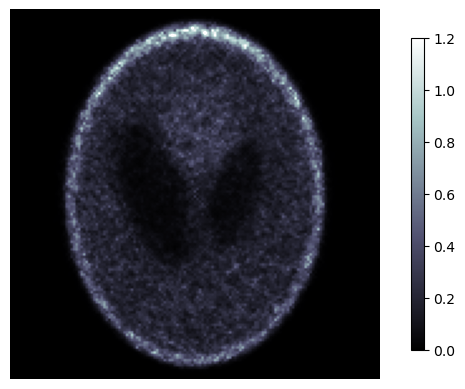

In [17]:
idx = 16

fig = plt.figure()

out = sol[19,:,idx,:].cpu().numpy()
im = plt.imshow(out, cmap='bone', clim=[0,1.2])
plt.axis('off')
cbar_ax = fig.add_axes([0.85, 0.17, 0.02, 0.65])
fig.colorbar(im, cax=cbar_ax)
plt.show()

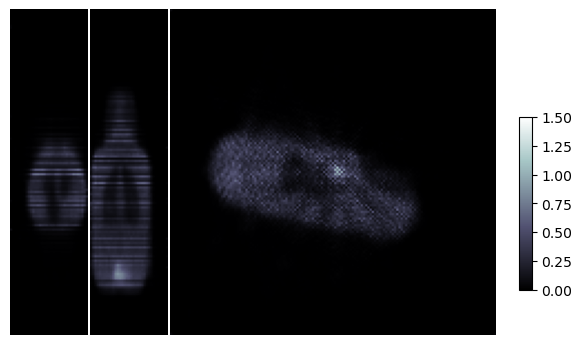

In [20]:
indices= [70,80,16]

fig = plt.figure()

gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 4.2, 0.1])

ax0 = plt.subplot(gs[0])
im0 = ax0.imshow(sol[19,:,:,indices[0]].cpu().numpy(), cmap='bone',clim=[0,1.5])
ax0.axis('off')

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(np.flip(sol[19,indices[1],:,:].cpu().numpy().T), cmap='bone',clim=[0,1.5])
ax1.axis('off')

ax2 = plt.subplot(gs[2])
im2 = ax2.imshow(sol[19,:,indices[2],:].cpu().numpy(), cmap='bone', clim=[0,1.5])
ax2.axis('off')

cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.36])
fig.colorbar(im0, cax=cbar_ax)

plt.subplots_adjust(wspace=0.02)
plt.show()